# Sheet 8

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
import os
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score


In [3]:
# Check if CUDA (GPU support for PyTorch) is available
print("GPU is", "available" if torch.cuda.is_available() else "not available")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

GPU is available
Using cuda device


## 1) Anomaly detection for Autoencoders

In [4]:
# load data
#fname = "data06/"
fname = "/content/drive/MyDrive/Colab Notebooks/data06/"
X_train = np.load( fname+"toptagging-short/x_train_short.npy")
y_train = np.load( fname+"toptagging-short/y_train_short.npy")
X_test = np.load( fname+"toptagging-short/x_test_short.npy")
y_test = np.load( fname+"toptagging-short/y_test_short.npy")
X_val = np.load( fname+"toptagging-short/x_val_short.npy")
y_val = np.load( fname+"toptagging-short/y_val_short.npy")

print(f"train data shape: {X_train.shape}")
print(f"train labels shape: {y_train.shape}")
print(f"test data shape: {X_test.shape}")
print(f"test labels shape: {y_test.shape}")
print(f"val data shape: {X_val.shape}")
print(f"val labels shape: {y_val.shape}")

train data shape: (30000, 200, 4)
train labels shape: (30000,)
test data shape: (30000, 200, 4)
test labels shape: (30000,)
val data shape: (30000, 200, 4)
val labels shape: (30000,)


In [5]:
# Some initial settings
__n_warning__ = 0.7
n_shift_phi, n_shift_eta = 0, 0

# Grid settings
xpixels = np.arange(-2.6, 2.6, 0.029)
ypixels = np.arange(-np.pi, np.pi, 0.035)

# Calculate the pseudorapidity of pixel entries
def eta (pT, pz):
    small = 1e-10
    small_pT = (np.abs(pT) < small)
    small_pz = (np.abs(pz) < small)
    not_small = ~(small_pT | small_pz)
    theta = np.arctan(pT[not_small]/pz[not_small])
    theta[theta < 0] += np.pi
    etas = np.zeros_like(pT)
    etas[small_pz] = 0
    etas[small_pT] = 1e-10
    etas[not_small] = np.log(np.tan(theta/2))
    return etas

# Calculate the azimuthal angle of pixel entries
def phi (px, py):
    """
    phis are returned in rad., np.arctan(0,0)=0 -> zero constituents set to -np.pi
    """
    phis = np.arctan2(py,px)
    phis[phis < 0] += 2*np.pi
    phis[phis > 2*np.pi] -= 2*np.pi
    phis = phis - np.pi
    return phis

# function to calculate masses
def mass (E,px,py,pz):
    mass = np.sqrt(np.maximum(0.,E**2-px**2-py**2-pz**2))
    return mass

# function to return the image momenta for centroid and principal axis
def img_mom (x, y, weights, x_power, y_power):
    return ((x**x_power)*(y**y_power)*weights).sum()

# returns the jet image
def orig_image (etas, phis, es):
    """
    Gives the value on grid with minimal distance,
    eg. for xpixel = (0,1,2,3,..) eta=1.3 -> xpixel=1, eta=1.6 ->xpixel=2
    """
    z = np.zeros((etas.shape[0],len(xpixels),len(ypixels)))
    in_grid = ~((etas < xpixels[0]) | (etas > xpixels[-1]) | (phis < ypixels[0]) | (phis > ypixels[-1]))
    xcoords = np.argmin(np.abs(etas[:,None,:] - xpixels[None,:,None]),axis=1)
    ycoords = np.argmin(np.abs(phis[:,None,:] - ypixels[None,:,None]),axis=1)
    ncoords = np.repeat(np.arange(etas.shape[0])[:,None],etas.shape[1],axis=1)
    z[ncoords[in_grid],ycoords[in_grid],xcoords[in_grid]] = es[in_grid]
    return z

# preprocess the jet
def preprocessing( x ,y, weights, rotate=True, flip=True ):
    """
    (x,y) are the coordinates and weights the corresponding values, shifts
    centroid to origin, rotates image, so that principal axis is vertical,
    flips image, so that most weights lay in (x<0, y>0)-plane.
    Method for calculating principal axis (similar to tensor of inertia):
    https://en.wikipedia.org/wiki/Image_moment
    here: y=phi, phi has modulo 2*np.pi but it's not been taken care of hear,
    so possible issues with calculating the centroid
    -> pre-shifting of events outside of this function solves the problem
    for iamge-data with Delta_phi < 2*np.pi
    """

    # Shift
    x_centroid = img_mom(x, y, weights, 1, 0) / weights.sum()
    y_centroid = img_mom(x, y, weights, 0, 1)/ weights.sum()
    x = x - x_centroid
    y = y - y_centroid

    # Check if shifting worked, there can be problems with modulo variables like phi (y)
    # x and y are sorted after highest weight, 0-comp. gives hottest event
    # for Jet-like Images Centroid should be close to hottest constituen (pT-sorted arrays)
    global n_shift_phi
    global n_shift_eta
    if np.abs(x[0]) > __n_warning__:
        n_shift_eta += 1
    if np.abs(y[0]) > __n_warning__:
        n_shift_phi += 1

    if rotate:
        #Ccovariant matrix, eigenvectors corr. to principal axis
        u11 = img_mom(x, y, weights, 1, 1) / weights.sum()
        u20 = img_mom(x, y, weights, 2, 0) / weights.sum()
        u02 = img_mom(x, y, weights, 0, 2) / weights.sum()
        cov = np.array([[u20, u11], [u11, u02]])

        # Eigenvalues and eigenvectors of covariant matrix
        evals, evecs = np.linalg.eig(cov)

        # Sorts the eigenvalues, v1, [::-1] turns array around,
        sort_indices = np.argsort(evals)[::-1]
        e_1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
        e_2 = evecs[:, sort_indices[1]]

        # Theta to x_asix, arctan2 gives correct angle
        theta = np.arctan2(e_1[0], e_1[1])

        # Rotation, so that princple axis is vertical
        # anti-clockwise rotation matrix
        rotation = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        transformed_mat = rotation * np.stack([x,y])
        x_rot, y_rot = transformed_mat.A
    else:
        x_rot, y_rot = x, y

    # Flipping
    n_flips = 0
    if flip:
        if weights[x_rot<0.].sum() < weights[x_rot>0.].sum():
            x_rot = -x_rot
            n_flips  += 1
        if weights[y_rot<0.].sum() > weights[y_rot>0.].sum():
            y_rot = -y_rot
            n_flips += 1

    return x_rot, y_rot


# function to convert the jet to an image
def constit_to_img( jets, n_constit, norm, rotate, flip ):

    print( "Crop constituents" )
    jets = jets[:,0:n_constit,:]

    print( "Calculating pT" )
    E     = jets[:,:,0]
    pxs   = jets[:,:,1]
    pys   = jets[:,:,2]
    pzs   = jets[:,:,3]
    pT    = np.sqrt(pxs**2+pys**2)

    print( "Calculating eta" )
    etas  = eta(pT,pzs)

    print( "Calculating phi" )
    phis  = phi(pxs,pys)

    print( "Calculating the mass" )
    E_tot = E.sum(axis=1)
    px_tot = pxs.sum(axis=1)
    py_tot = pys.sum(axis=1)
    pz_tot = pzs.sum(axis=1)
    j_mass = mass(E_tot, px_tot, py_tot, pz_tot)

    print( "Pre-shifting the phis" )
    phis = (phis.T - phis[:,0]).T
    phis[phis < -np.pi] += 2*np.pi
    phis[phis > np.pi] -= 2*np.pi

    print( "Using pT as weight" )
    weights = pT

    print( "Preprocessing" )

    for i in range( np.shape(etas)[0] ):
        etas[i,:], phis[i,:] = preprocessing( etas[i,:], phis[i,:], weights[i,:], rotate, flip )

    print( "Creating images" )
    z_ori = orig_image(etas, phis, weights)

    #return z_ori

    print( "Cropping and normalising" )
    n_crop = 40
    z_new = np.zeros( (z_ori.shape[0],n_crop, n_crop) )
    for i in range(z_ori.shape[0]):
        Npix = z_ori[i,:,:].shape
        z_new[i,:,:] = z_ori[i, int(Npix[0]/2-n_crop/2) : int(Npix[0]/2+n_crop/2), int(Npix[1]/2-n_crop/2) : int(Npix[1]/2+n_crop/2) ]
        if norm:
            z_sum = z_new[i,:,:].sum()
            if z_sum != 0.:
                z_new[i,:,:] = z_new[i,:,:]/z_sum

    print( "Reshaping" )
    z_out = z_new.reshape( (z_new.shape[0],-1) ).reshape(-1, 1, 40,40)

    return z_out

In [6]:
z_train = constit_to_img( X_train, 50, True, True, True )
z_val = constit_to_img( X_val, 50, True, True, True )
z_test = constit_to_img( X_test, 50, True, True, True )

Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping


(a)

In [ ]:
# TODO: Construct autoencoder

#only taking the QCD jets of each set
QCD_train = torch.Tensor(z_train[np.where(y_train==0)]).float()
QCD_test = torch.Tensor(z_test[np.where(y_test==0)]).float()
QCD_val = torch.Tensor(z_val[np.where(y_val==0)]).float()

In [ ]:
#building QCD jet only dataclass and dataloaders

from torch.utils.data import Dataset, DataLoader

class QCDData(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

train_qcd_dataset = QCDData(torch.flatten(QCD_train, start_dim=1))
test_qcd_dataset = QCDData(torch.flatten(QCD_test, start_dim=1))
val_qcd_dataset = QCDData(torch.flatten(QCD_val, start_dim=1))

batch_size = 100

trn_qcd_mlp = DataLoader(train_qcd_dataset, batch_size=batch_size, shuffle=True)
tst_qcd_mlp = DataLoader(test_qcd_dataset, batch_size=batch_size, shuffle=False)
val_qcd_mlp = DataLoader(val_qcd_dataset, batch_size=batch_size, shuffle=False)


In [ ]:


class MLP_autoencoder(nn.Module):

    def __init__(self, bottleneck_dim=20, n_hidden_layers=1, hidden_dim=400, img_sz=40):
        super(MLP_autoencoder, self).__init__()

        self.in_en_layer = nn.Linear(in_features=img_sz**2, out_features=hidden_dim)
        self.out_en_layer = nn.Linear(in_features=hidden_dim, out_features=bottleneck_dim)
        self.hidden_layers = nn.ModuleList([nn.Linear(in_features=hidden_dim, out_features=hidden_dim) for _ in range(n_hidden_layers)])
        self.out_de_layer = nn.Linear(in_features=hidden_dim, out_features=img_sz**2)
        self.in_de_layer = nn.Linear(in_features=bottleneck_dim, out_features=hidden_dim)

        self.encoder = nn.Sequential(
            self.in_en_layer,
            nn.ReLU(),
            *self.hidden_layers,
            nn.ReLU(), 
            self.out_en_layer)
        
        self.decoder = nn.Sequential(
            self.in_de_layer, 
            nn.ReLU(), 
            *self.hidden_layers[::-1],
            nn.ReLU(), 
            self.out_de_layer)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


(b)

In [ ]:
# TODO: Train autoencoder on QCD jets
# Choose the bottleneck dimension between 5 and 20



mlp_qcd = MLP_autoencoder().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(mlp_qcd.parameters(), lr=1e-3)

trn_loss = []
val_loss = []
n_epochs = 100

for epoch in tqdm(range(n_epochs), desc="Training Progress"):
    # Training of model
    for img in trn_qcd_mlp:
        img = img.to(device)

        optimizer.zero_grad()
        pred = mlp_qcd(img)
        loss = loss_fn(pred, img)
        loss.backward()
        optimizer.step()

        trn_loss.append(loss.item())

    # Validation of model for each epoch
    with torch.no_grad():
        single_val_loss = []
        for img in val_qcd_mlp:
            img = img.to(device)
            pred = mlp_qcd(img)
            loss = loss_fn(pred, img)
            single_val_loss.append(loss.item())

        val_loss.append(np.mean(single_val_loss))


Training Progress: 100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


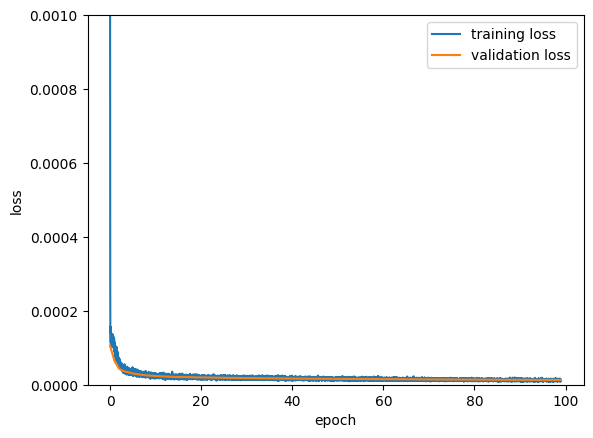

In [ ]:
#plotting the loss
plt.plot(np.linspace(0,n_epochs-1,len(trn_loss)), trn_loss,label="training loss")
plt.plot(np.arange(n_epochs),val_loss,label="validation loss")
plt.ylim(0,1e-3)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

(c)

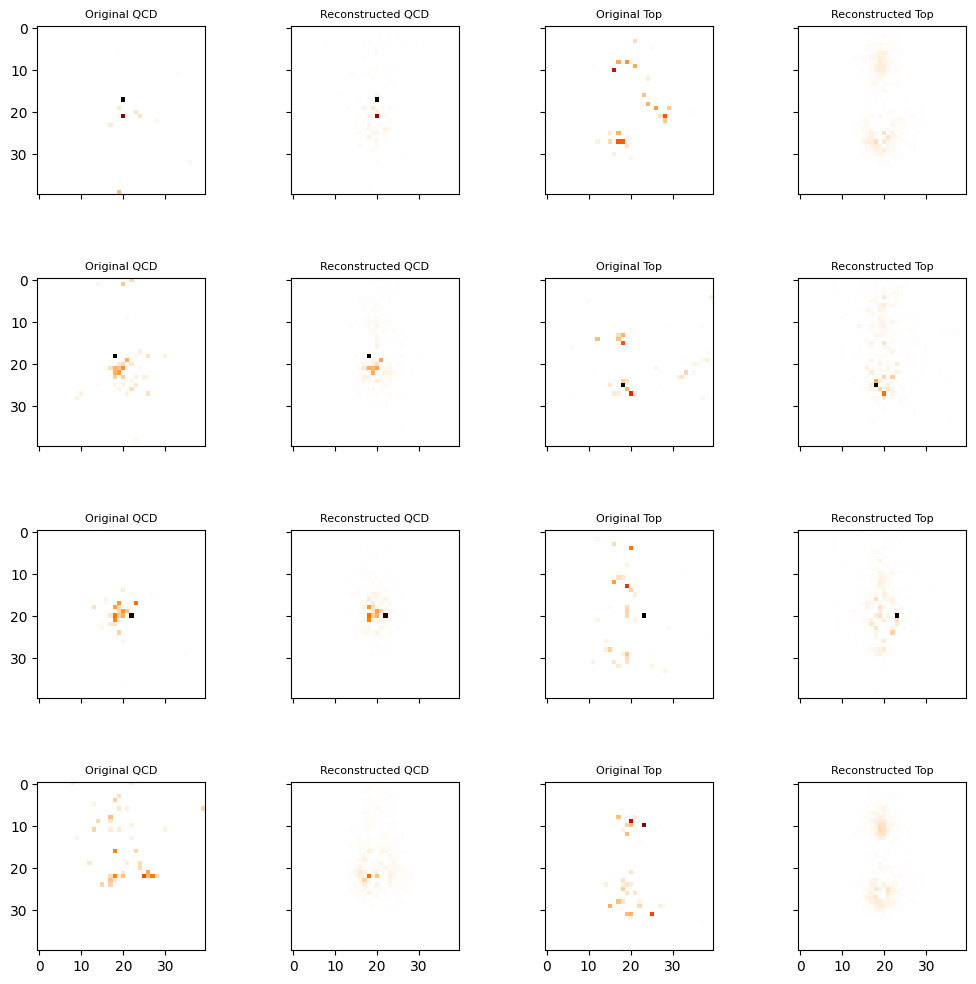

In [ ]:
# TODO: Visualize original vs reconstructed QCD and top jets

mse_loss = nn.MSELoss(reduction='none')

qcd_test = torch.Tensor(z_test[np.where(y_test==0)]).float().to(device)
top_test = torch.Tensor(z_test[np.where(y_test==1)]).float().to(device)

qcd_test = torch.flatten(qcd_test[:4, 0, :, :], start_dim=1)
top_test = torch.flatten(top_test[:4, 0, :, :], start_dim=1)

with torch.no_grad():
    qcd_pred = mlp_qcd(qcd_test)
    qcd_mse = mse_loss(qcd_pred, qcd_test).cpu().detach().numpy()
    qcd_pred = np.reshape(qcd_pred.cpu().detach().numpy(), (4, 40, 40))

    top_pred = mlp_qcd(top_test)
    top_mse = mse_loss(top_pred, top_test).cpu().detach().numpy()
    top_pred = np.reshape(top_pred.cpu().detach().numpy(), (4, 40, 40))

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(12, 12), sharey=True, sharex=True)
titles = ["Original QCD", "Reconstructed QCD", "Original Top", "Reconstructed Top"]

for row in range(4):
    for col in range(4):
        if col == 0:
            axs[row, col].imshow(qcd_test[row].cpu().reshape(40, 40), cmap="gist_heat_r", vmin=0.0, vmax=0.3)
        elif col == 1:
            axs[row, col].imshow(qcd_pred[row], cmap="gist_heat_r", vmin=0.0, vmax=0.3)
        elif col == 2:
            axs[row, col].imshow(top_test[row].cpu().reshape(40, 40), cmap="gist_heat_r", vmin=0.0, vmax=0.3)
        elif col == 3:
            axs[row, col].imshow(top_pred[row], cmap="gist_heat_r", vmin=0.0, vmax=0.3)

        axs[row, col].set_title(titles[col], fontsize=8)

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()


(d)

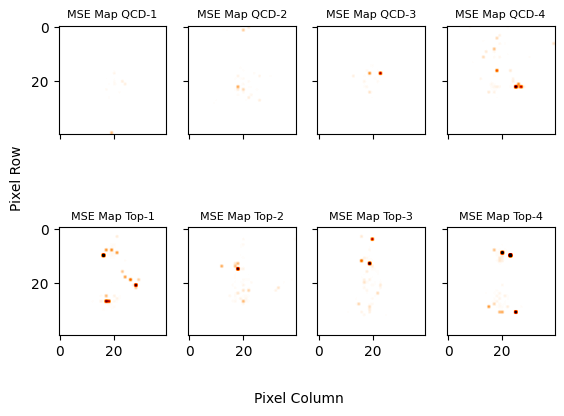

In [ ]:
# TODO: Visualize pixel-wise MSE, plot ROC

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 12), sharey=True, sharex=True)

# Reshape the MSE arrays for QCD and Top jets
mse_qcd = np.reshape(qcd_mse, (4, 40, 40))
mse_top = np.reshape(top_mse, (4, 40, 40))

# Plot the MSE maps for QCD jets
for i in range(4):
    axs[0, i].imshow(mse_qcd[i], cmap="gist_heat_r", vmin=0.0, vmax=0.01)
    axs[0, i].set_title(f'MSE Map QCD-{i + 1}', fontsize=8)  # Add title for QCD jets

# Plot the MSE maps for Top jets
for i in range(4):
    axs[1, i].imshow(mse_top[i], cmap="gist_heat_r", vmin=0.0, vmax=0.01)
    axs[1, i].set_title(f'MSE Map Top-{i + 1}', fontsize=8)  # Add title for Top jets

# Add labels
fig.text(0.5, 0.04, 'Pixel Column', ha='center', va='center')
fig.text(0.06, 0.5, 'Pixel Row', ha='center', va='center', rotation='vertical')


plt.show()


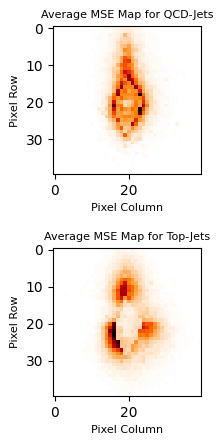

In [ ]:
# TODO: convert to tensor and flatten the data
TOP_test = torch.flatten(torch.Tensor(z_test[y_test == 1]).float(), start_dim=1)
QCD_test = torch.flatten(QCD_test, start_dim=1)

# TODO: calculation of MSE for Top-Jets and QCD-Jets
with torch.no_grad():
    TOP_test, QCD_test = TOP_test.to(device), QCD_test.to(device)

    pred_top, pred_qcd = mlp_qcd(TOP_test), mlp_qcd(QCD_test)

    mse_top = nn.MSELoss(reduction='none')(pred_top, TOP_test).cpu().detach().numpy()
    mse_top = mse_top.reshape((TOP_test.shape[0], 40, 40))

    mse_qcd = nn.MSELoss(reduction='none')(pred_qcd, QCD_test).cpu().detach().numpy()
    mse_qcd = mse_qcd.reshape((QCD_test.shape[0], 40, 40))

# TODO: MSE over all Pixel for each picture
test_mse = np.concatenate([np.mean(mse_qcd, axis=(-1, -2)), np.mean(mse_top, axis=(-1, -2))])

# TODO: Labels for testdata
y_test_mse = np.concatenate([np.zeros(mse_qcd.shape[0]), np.ones(mse_top.shape[0])])

# TODO: MSE for all QCD-Jets and Top-Jets
mse_qcd, mse_top = np.mean(mse_qcd, axis=0), np.mean(mse_top, axis=0)


fig, [ax0, ax1] = plt.subplots(2)
ax0.imshow(mse_qcd, cmap="gist_heat_r")
ax0.set_title("Average MSE Map for QCD-Jets",fontsize=8)
ax0.set_xlabel("Pixel Column", fontsize= 8)
ax0.set_ylabel("Pixel Row", fontsize= 8)

ax1.imshow(mse_top, cmap="gist_heat_r")
ax1.set_title("Average MSE Map for Top-Jets", fontsize= 8)
ax1.set_xlabel("Pixel Column", fontsize= 8)
ax1.set_ylabel("Pixel Row", fontsize= 8)

plt.subplots_adjust(hspace=0.5)

plt.show()


(30000,) (30000,)


<ipython-input-15-d5cf74675a3e>:25: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(tpr, 1/fpr, label=f'AUC = {auc_score:.2f}\n $1/\epsilon_{{bkg}}$(0.3) = {1/fpr[closest_point(tpr, tpr_p=0.3)]:.0f}' if 0 in fpr else '')
<ipython-input-15-d5cf74675a3e>:26: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(rnd_class, 1/rnd_class, '--', label='Rnd classifier' if 0 not in rnd_class else '')


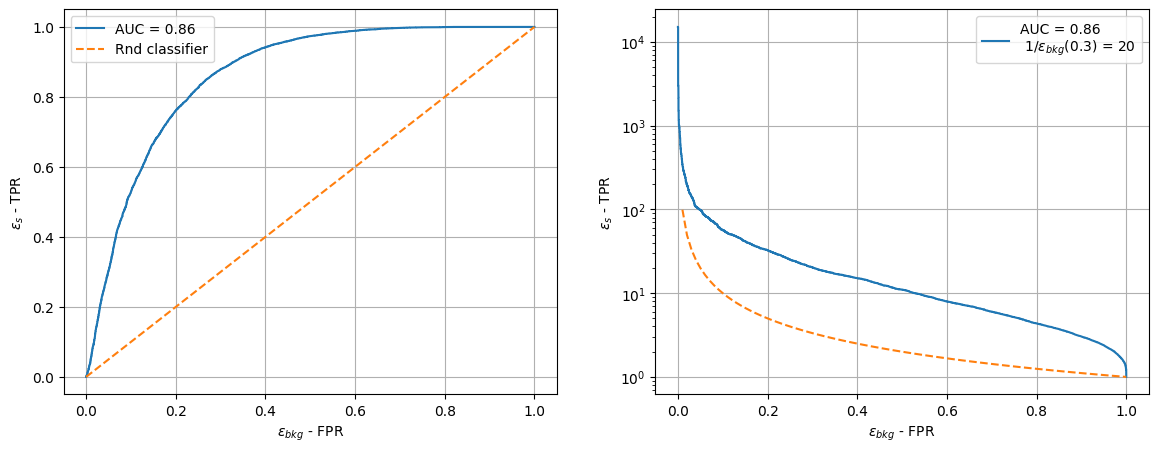

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# function to find the next point to a given value
def closest_point(array, tpr_p=0.3):
    return np.argmin((array - tpr_p) ** 2)


fig, ax = plt.subplots(1, 2, figsize=(14, 5))


print(y_test_mse.shape, test_mse.shape)

# calculate ROC-Kurve-Parameter and AUC Value
fpr, tpr, th = roc_curve(y_test_mse, test_mse)
auc_score = roc_auc_score(y_test_mse, test_mse)

# generate array for random classifier
rnd_class = np.linspace(0, 1, 100)


ax[0].plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
ax[0].plot(rnd_class, rnd_class, '--', label='Rnd classifier')


ax[1].plot(tpr, 1/fpr, label=f'AUC = {auc_score:.2f}\n $1/\epsilon_{{bkg}}$(0.3) = {1/fpr[closest_point(tpr, tpr_p=0.3)]:.0f}' if 0 in fpr else '')
ax[1].plot(rnd_class, 1/rnd_class, '--', label='Rnd classifier' if 0 not in rnd_class else '')

ax[1].set_yscale('log')


for ax_i in ax:
    ax_i.set_xlabel('$\epsilon_{bkg}$ - FPR')
    ax_i.set_ylabel('$\epsilon_{s}$ - TPR')
    ax_i.legend()
    ax_i.tick_params()
    ax_i.grid(True)


plt.show()


(e)

In [ ]:
# TODO: Repeat everything for CNN
class cnn_data(torch.utils.data.Dataset):
    def __init__(self, imgs):
        self.imgs = imgs

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        return self.imgs[idx]


batch_size = 100

trn_qcd_cnn = torch.utils.data.DataLoader(cnn_data(QCD_train), batch_size=batch_size, shuffle=True)
tst_qcd_cnn = torch.utils.data.DataLoader(cnn_data(QCD_test), batch_size=batch_size, shuffle=False)
val_qcd_cnn = torch.utils.data.DataLoader(cnn_data(QCD_val), batch_size=batch_size, shuffle=False)


In [ ]:

class CNN_autoencoder(nn.Module):

    def __init__(self, in_ch=1, ch=32, bottleneck_dim=15, img_sz=40):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, ch, kernel_size=3, bias=True, stride=1, padding=1)
        self.conv2 = nn.Conv2d(ch, 2*ch, kernel_size=3, bias=True, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.flatten = nn.Flatten()
        self.out = nn.Linear(int(2*ch*img_sz*img_sz/16), bottleneck_dim, bias=True)
        self.relu = nn.ReLU()

        self.de_in = nn.Linear(bottleneck_dim, int(2*ch*img_sz*img_sz/16), bias=True)
        self.unflatten = nn.Unflatten(1,(2*ch,int(img_sz/4),int(img_sz/4)))
        self.convtranspose1 = nn.Conv2d(2*ch, ch, kernel_size=3, bias=True, stride=1, padding=1)
        self.convtranspose2 = nn.Conv2d(ch, in_ch, kernel_size=3, bias=True, stride=1, padding=1)
        self.maxunpool = nn.MaxUnpool2d(kernel_size=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x, indices1 = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x, indices2 = self.maxpool(x)
        x = self.flatten(x)
        x = self.out(x)

        x = self.de_in(x)
        x = self.unflatten(x)
        x = self.maxunpool(x,indices2)
        x = self.relu(x)
        x = self.convtranspose1(x)
        x = self.maxunpool(x,indices1)
        x = self.relu(x)
        x = self.convtranspose2(x)
        return x

In [ ]:
# TODO: Train autoencoder on QCD jets
# Choose the bottleneck dimension between 5 and 20



cnn_qcd = CNN_autoencoder().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_qcd.parameters(), lr=1e-3)

trn_loss = []
val_loss = []
n_epochs = 150

for epoch in tqdm(range(n_epochs), desc="Training Progress"):
    # Training of model
    for img in trn_qcd_cnn:
        img = img.to(device)

        optimizer.zero_grad()
        pred = cnn_qcd(img)
        loss = loss_fn(pred, img)
        loss.backward()
        optimizer.step()

        trn_loss.append(loss.item())

    # validiation of model in each epoch
    with torch.no_grad():
        single_val_loss = []
        for img in val_qcd_cnn:
            img = img.to(device)
            pred = cnn_qcd(img)
            loss = loss_fn(pred, img)
            single_val_loss.append(loss.item())

        val_loss.append(np.mean(single_val_loss))


Training Progress: 100%|██████████| 150/150 [05:21<00:00,  2.14s/it]


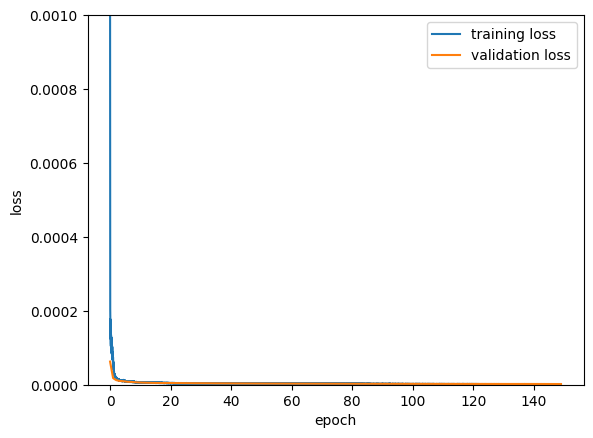

In [ ]:
#plotting the loss
plt.plot(np.linspace(0,n_epochs-1,len(trn_loss)), trn_loss,label="training loss")
plt.plot(np.arange(n_epochs),val_loss,label="validation loss")
plt.ylim(0,1e-3)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

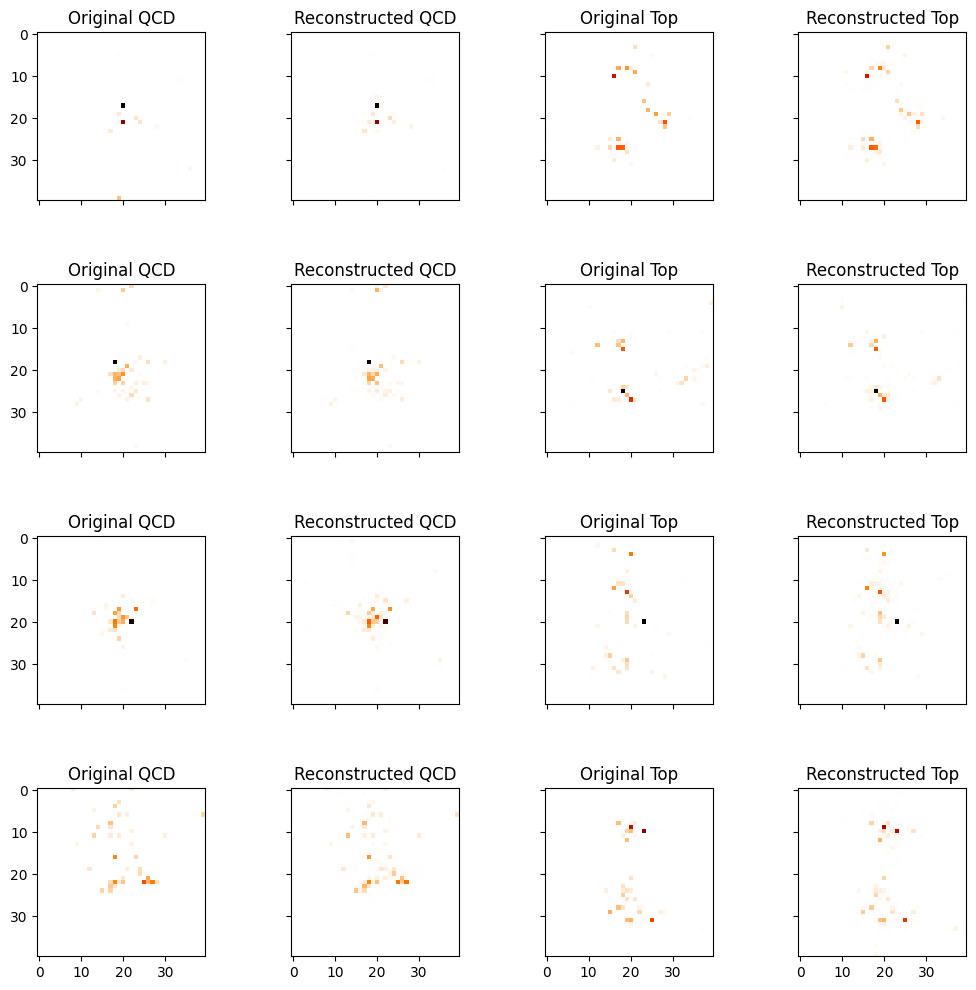

In [ ]:
# TODO: Visualize original vs reconstructed QCD and top jets

mse_loss = nn.MSELoss(reduction='none')

# Load test data
qcd_test = torch.Tensor(z_test[np.where(y_test == 0)]).float().to(device)
top_test = torch.Tensor(z_test[np.where(y_test == 1)]).float().to(device)

# Generate predictions
qcd_pred = cnn_qcd(qcd_test[0:4, :, :, :])
top_pred = cnn_qcd(top_test[0:4, :, :, :])

# Compute MSE
qcd_mse = mse_loss(qcd_pred, qcd_test[0:4, :, :, :]).cpu().detach().numpy()
top_mse = mse_loss(top_pred, top_test[0:4, :, :, :]).cpu().detach().numpy()

# Reshape predictions for visualization
qcd_pred = np.reshape(qcd_pred.cpu().detach().numpy(), (4, 40, 40))
top_pred = np.reshape(top_pred.cpu().detach().numpy(), (4, 40, 40))


fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(12, 12), sharey=True, sharex=True)

# Plot original QCD images
for i in range(4):
    axs[i,0].imshow(qcd_test[i, 0].cpu(), cmap="gist_heat_r", vmin=0.0, vmax=0.3)
    axs[i,0].set_title("Original QCD")

# Plot reconstructed QCD images
for i in range(4):
    axs[i,1].imshow(qcd_pred[i], cmap="gist_heat_r", vmin=0.0, vmax=0.3)
    axs[i,1].set_title("Reconstructed QCD")

# Plot original Top images
for i in range(4):
    axs[i,2].imshow(top_test[i, 0].cpu(), cmap="gist_heat_r", vmin=0.0, vmax=0.3)
    axs[i,2].set_title("Original Top")

# Plot reconstructed Top images
for i in range(4):
    axs[i,3].imshow(top_pred[i], cmap="gist_heat_r", vmin=0.0, vmax=0.3)
    axs[i,3].set_title("Reconstructed Top")


plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()



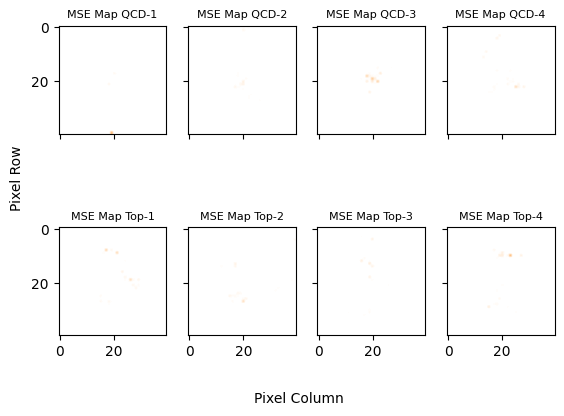

In [ ]:
# TODO: Visualize pixel-wise MSE, plot ROC

fig, axs = plt.subplots(nrows=2, ncols=4, sharey=True, sharex=True)

# Reshape the MSE arrays for QCD and Top jets
mse_qcd = np.reshape(qcd_mse, (4, 40, 40))
mse_top = np.reshape(top_mse, (4, 40, 40))

# Plot the MSE maps for QCD jets
for i in range(4):
    axs[0, i].imshow(mse_qcd[i], cmap="gist_heat_r", vmin=0.0, vmax=0.01)
    axs[0, i].set_title(f'MSE Map QCD-{i + 1}', fontsize=8)

# Plot the MSE maps for Top jets
for i in range(4):
    axs[1, i].imshow(mse_top[i], cmap="gist_heat_r", vmin=0.0, vmax=0.01)
    axs[1, i].set_title(f'MSE Map Top-{i + 1}', fontsize=8)


fig.text(0.5, 0.04, 'Pixel Column', ha='center', va='center')
fig.text(0.06, 0.5, 'Pixel Row', ha='center', va='center', rotation='vertical')

plt.show()


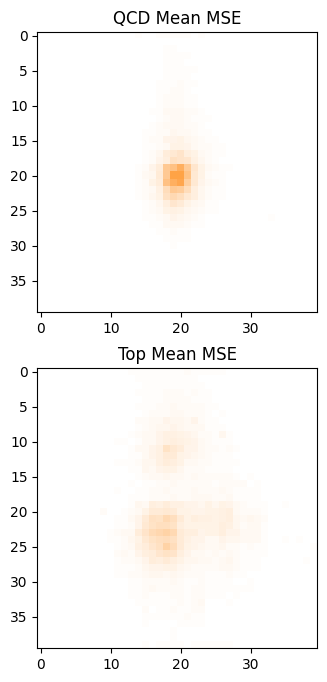

In [ ]:
test_loss = nn.MSELoss(reduction='none')

# Convert test data to tensors
TOP_test = torch.Tensor(z_test[np.where(y_test == 1)]).float()
QCD_test = torch.Tensor(z_test[np.where(y_test == 0)]).float()

# Move tensors to device
TOP_test = TOP_test.to(device)
QCD_test = QCD_test.to(device)

# Generate predictions and compute MSE
with torch.no_grad():
    pred_top = cnn_qcd(TOP_test)
    mse_top = test_loss(pred_top, TOP_test).cpu().detach().numpy()
    mse_top = np.reshape(mse_top, (TOP_test.shape[0], 40, 40))

    pred_qcd = cnn_qcd(QCD_test)
    mse_qcd = test_loss(pred_qcd, QCD_test).cpu().detach().numpy()
    mse_qcd = np.reshape(mse_qcd, (QCD_test.shape[0], 40, 40))

# Calculate mean MSE and labels
test_mse = np.append(np.mean(mse_qcd, axis=(-1, -2)), np.mean(mse_top, axis=(-1, -2)))
y_test_mse = np.append(np.zeros(mse_qcd.shape[0]), np.ones(mse_top.shape[0]))

# Calculate mean MSE for visualization
mse_qcd_mean = np.mean(mse_qcd, axis=0)
mse_top_mean = np.mean(mse_top, axis=0)

# Plotting
fig, [ax0, ax1] = plt.subplots(2, figsize=(8, 8))
ax0.imshow(mse_qcd_mean, vmin=0, vmax=0.0005, cmap="gist_heat_r")
ax0.set_title("QCD Mean MSE")

ax1.imshow(mse_top_mean, vmin=0, vmax=0.0005, cmap="gist_heat_r")
ax1.set_title("Top Mean MSE")

plt.show()



(30000,) (30000,)


<ipython-input-46-6fdebfaa2ff4>:23: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(tpr, 1/fpr, label=f'AUC = {auc_score:.2f}\n $1/\epsilon_{{bkg}}$(0.3) = {1/fpr[closest_point(tpr, tpr_p=0.3)]:.0f}' if 0 in fpr else '')
<ipython-input-46-6fdebfaa2ff4>:24: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(rnd_class, 1/rnd_class, '--', label='Rnd classifier' if 0 not in rnd_class else '')


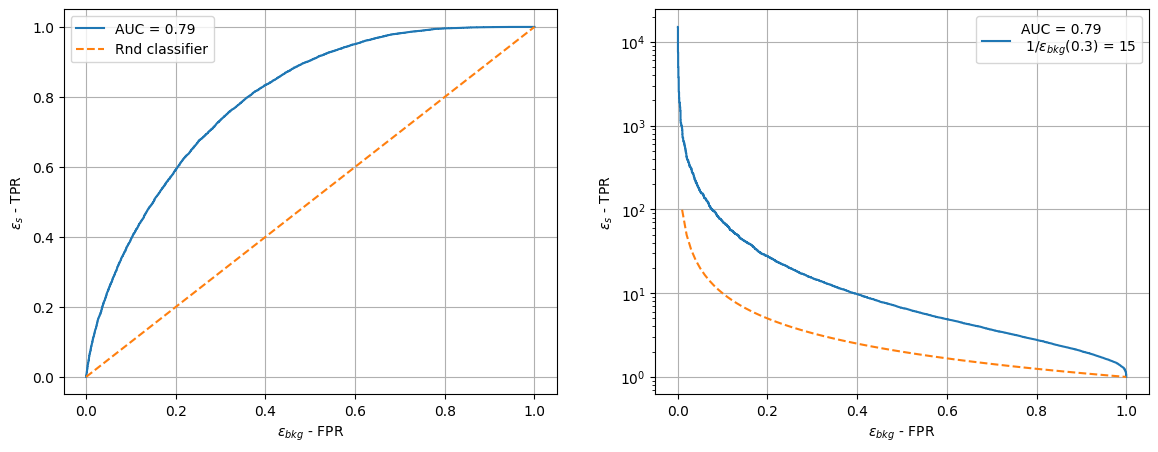

In [ ]:
# function to search next point to a given value
def closest_point(array, tpr_p=0.3):
    return np.argmin((array - tpr_p) ** 2)


fig, ax = plt.subplots(1, 2, figsize=(14, 5))


print(y_test_mse.shape, test_mse.shape)

#calculate ROC-Kurve-Parameter (fpr, tpr, Schwellenwert) and AUC-Value
fpr, tpr, th = roc_curve(y_test_mse, test_mse)
auc_score = roc_auc_score(y_test_mse, test_mse)

# Generate Array for random classifier
rnd_class = np.linspace(0, 1, 100)


ax[0].plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
ax[0].plot(rnd_class, rnd_class, '--', label='Rnd classifier')


ax[1].plot(tpr, 1/fpr, label=f'AUC = {auc_score:.2f}\n $1/\epsilon_{{bkg}}$(0.3) = {1/fpr[closest_point(tpr, tpr_p=0.3)]:.0f}' if 0 in fpr else '')
ax[1].plot(rnd_class, 1/rnd_class, '--', label='Rnd classifier' if 0 not in rnd_class else '')


ax[1].set_yscale('log')

for ax_i in ax:
    ax_i.set_xlabel('$\epsilon_{bkg}$ - FPR')
    ax_i.set_ylabel('$\epsilon_{s}$ - TPR')
    ax_i.legend()
    ax_i.tick_params()
    ax_i.grid(True)

plt.show()

(f)

In [23]:
# TODO: Repeat everything for autoencoder trained on top jets
# You can either use a MLP or a CNN

# TODO: Construct autoencoder with MLP

#only taking the Top jets of each set
top_train = torch.Tensor(z_train[np.where(y_train==1)]).float()
top_test = torch.Tensor(z_test[np.where(y_test==1)]).float()
top_val = torch.Tensor(z_val[np.where(y_val==1)]).float()

In [24]:
#building top jet only dataclass and dataloaders

from torch.utils.data import Dataset, DataLoader

class TOPData(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

train_top_dataset = TOPData(torch.flatten(top_train, start_dim=1))
test_top_dataset = TOPData(torch.flatten(top_test, start_dim=1))
val_top_dataset = TOPData(torch.flatten(top_val, start_dim=1))

batch_size = 100

trn_top_mlp = DataLoader(train_top_dataset, batch_size=batch_size, shuffle=True)
tst_top_mlp = DataLoader(test_top_dataset, batch_size=batch_size, shuffle=False)
val_top_mlp = DataLoader(val_top_dataset, batch_size=batch_size, shuffle=False)

In [25]:
class MLP_autoencoder(nn.Module):

    def __init__(self, bottleneck_dim=20, n_hidden_layers=1, hidden_dim=400, img_sz=40):
        super(MLP_autoencoder, self).__init__()

        self.in_en_layer = nn.Linear(in_features=img_sz**2, out_features=hidden_dim)
        self.out_en_layer = nn.Linear(in_features=hidden_dim, out_features=bottleneck_dim)
        self.hidden_layers = nn.ModuleList([nn.Linear(in_features=hidden_dim, out_features=hidden_dim) for _ in range(n_hidden_layers)])
        self.out_de_layer = nn.Linear(in_features=hidden_dim, out_features=img_sz**2)
        self.in_de_layer = nn.Linear(in_features=bottleneck_dim, out_features=hidden_dim)

        self.encoder = nn.Sequential(self.in_en_layer, nn.ReLU(), *self.hidden_layers, nn.ReLU(), self.out_en_layer)
        self.decoder = nn.Sequential(self.in_de_layer, nn.ReLU(), *self.hidden_layers[::-1], nn.ReLU(), self.out_de_layer)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [26]:
# TODO: Train autoencoder on Top jets
# Choose the bottleneck dimension between 5 and 20

from tqdm import tqdm

mlp_top = MLP_autoencoder().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(mlp_top.parameters(), lr=1e-3)

trn_loss = []
val_loss = []
n_epochs = 150

for epoch in tqdm(range(n_epochs), desc="Training Progress"):
    #training of model
    for img in trn_top_mlp:
        img = img.to(device)

        optimizer.zero_grad()
        pred = mlp_top(img)
        loss = loss_fn(pred, img)
        loss.backward()
        optimizer.step()

        trn_loss.append(loss.item())

    # Validation of model for each epoch
    with torch.no_grad():
        single_val_loss = []
        for img in val_top_mlp:
            img = img.to(device)
            pred = mlp_top(img)
            loss = loss_fn(pred, img)
            single_val_loss.append(loss.item())

        val_loss.append(np.mean(single_val_loss))


Training Progress: 100%|██████████| 150/150 [01:37<00:00,  1.53it/s]


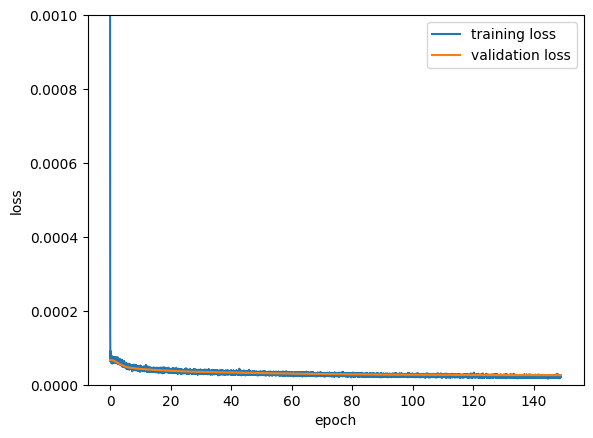

In [27]:
#plotting the loss
plt.plot(np.linspace(0,n_epochs-1,len(trn_loss)), trn_loss,label="training loss")
plt.plot(np.arange(n_epochs),val_loss,label="validation loss")
plt.ylim(0,1e-3)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

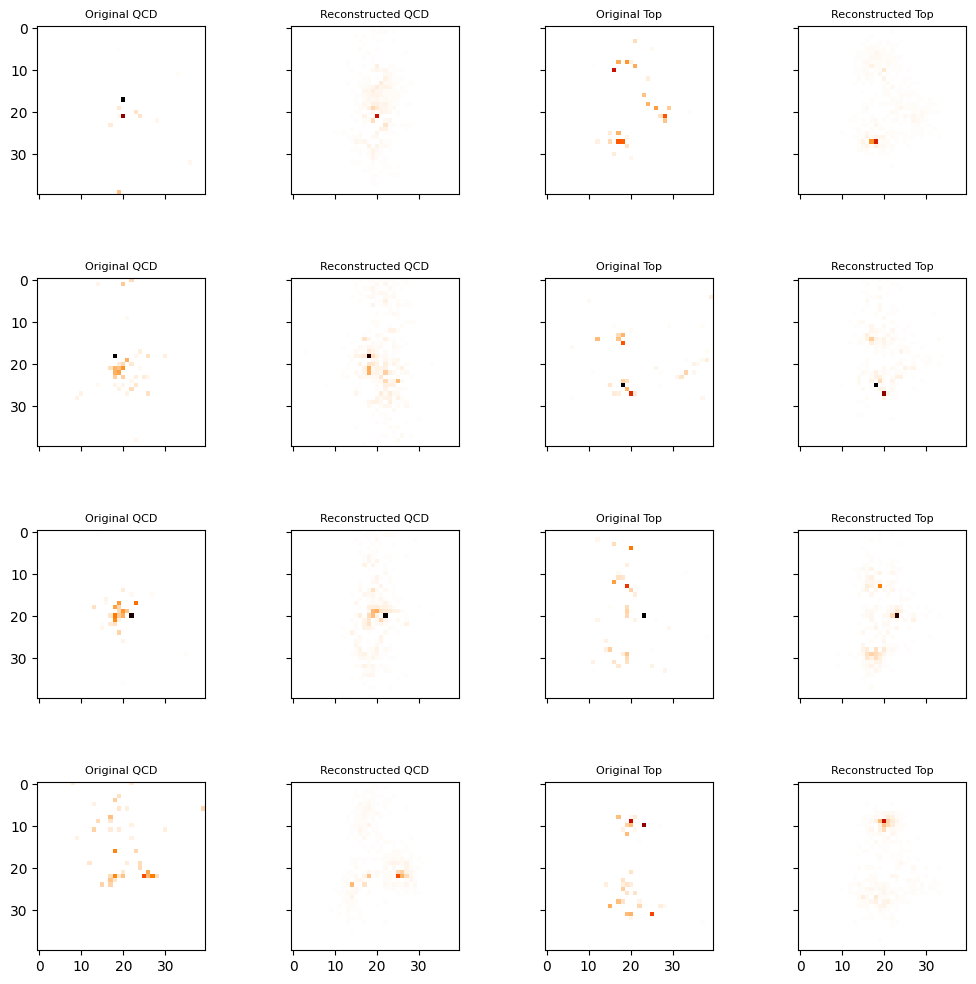

In [28]:
# TODO: Visualize original vs reconstructed QCD and top jets

mse_loss = nn.MSELoss(reduction='none')

qcd_test = torch.Tensor(z_test[np.where(y_test==0)]).float().to(device)
top_test = torch.Tensor(z_test[np.where(y_test==1)]).float().to(device)

qcd_test = torch.flatten(qcd_test[:4, 0, :, :], start_dim=1)
top_test = torch.flatten(top_test[:4, 0, :, :], start_dim=1)

with torch.no_grad():
    qcd_pred = mlp_top(qcd_test)
    qcd_mse = mse_loss(qcd_pred, qcd_test).cpu().detach().numpy()
    qcd_pred = np.reshape(qcd_pred.cpu().detach().numpy(), (4, 40, 40))

    top_pred = mlp_top(top_test)
    top_mse = mse_loss(top_pred, top_test).cpu().detach().numpy()
    top_pred = np.reshape(top_pred.cpu().detach().numpy(), (4, 40, 40))

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(12, 12), sharey=True, sharex=True)
titles = ["Original QCD", "Reconstructed QCD", "Original Top", "Reconstructed Top"]

for row in range(4):
    for col in range(4):
        if col == 0:
            axs[row, col].imshow(qcd_test[row].cpu().reshape(40, 40), cmap="gist_heat_r", vmin=0.0, vmax=0.3)
        elif col == 1:
            axs[row, col].imshow(qcd_pred[row], cmap="gist_heat_r", vmin=0.0, vmax=0.3)
        elif col == 2:
            axs[row, col].imshow(top_test[row].cpu().reshape(40, 40), cmap="gist_heat_r", vmin=0.0, vmax=0.3)
        elif col == 3:
            axs[row, col].imshow(top_pred[row], cmap="gist_heat_r", vmin=0.0, vmax=0.3)

        axs[row, col].set_title(titles[col], fontsize=8)

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

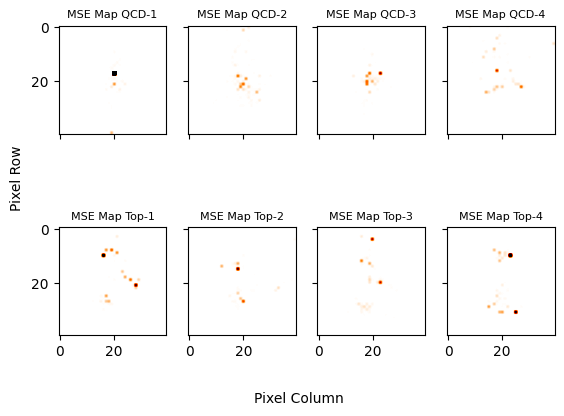

In [29]:
# TODO: Visualize pixel-wise MSE, plot ROC

fig, axs = plt.subplots(nrows=2, ncols=4, sharey=True, sharex=True)

# Reshape the MSE arrays for QCD and Top jets
mse_qcd = np.reshape(qcd_mse, (4, 40, 40))
mse_top = np.reshape(top_mse, (4, 40, 40))

# Plot the MSE maps for QCD jets
for i in range(4):
    axs[0, i].imshow(mse_qcd[i], cmap="gist_heat_r", vmin=0.0, vmax=0.01)
    axs[0, i].set_title(f'MSE Map QCD-{i + 1}', fontsize=8)  # Add title for QCD jets

# Plot the MSE maps for Top jets
for i in range(4):
    axs[1, i].imshow(mse_top[i], cmap="gist_heat_r", vmin=0.0, vmax=0.01)
    axs[1, i].set_title(f'MSE Map Top-{i + 1}', fontsize=8)  # Add title for Top jets


fig.text(0.5, 0.04, 'Pixel Column', ha='center', va='center')
fig.text(0.06, 0.5, 'Pixel Row', ha='center', va='center', rotation='vertical')


plt.show()

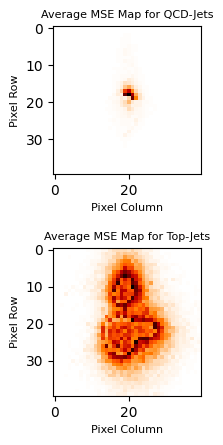

In [30]:
#  convert to tensor and flatten the data
TOP_test = torch.flatten(torch.Tensor(z_test[y_test == 1]).float(), start_dim=1)
QCD_test = torch.flatten(QCD_test, start_dim=1)

# calculation of MSE for Top-Jets and QCD-Jets
with torch.no_grad():
    TOP_test, QCD_test = TOP_test.to(device), QCD_test.to(device)

    pred_top, pred_qcd = mlp_top(TOP_test), mlp_top(QCD_test)

    mse_top = nn.MSELoss(reduction='none')(pred_top, TOP_test).cpu().detach().numpy()
    mse_top = mse_top.reshape((TOP_test.shape[0], 40, 40))

    mse_qcd = nn.MSELoss(reduction='none')(pred_qcd, QCD_test).cpu().detach().numpy()
    mse_qcd = mse_qcd.reshape((QCD_test.shape[0], 40, 40))

# MSE over all Pixel for each immage
test_mse = np.concatenate([np.mean(mse_qcd, axis=(-1, -2)), np.mean(mse_top, axis=(-1, -2))])


y_test_mse = np.concatenate([np.zeros(mse_qcd.shape[0]), np.ones(mse_top.shape[0])])

#  MSE for QCD-Jets and Top-Jets
mse_qcd, mse_top = np.mean(mse_qcd, axis=0), np.mean(mse_top, axis=0)


fig, [ax0, ax1] = plt.subplots(2)
ax0.imshow(mse_qcd, cmap="gist_heat_r")
ax0.set_title("Average MSE Map for QCD-Jets",fontsize=8)
ax0.set_xlabel("Pixel Column", fontsize= 8)
ax0.set_ylabel("Pixel Row", fontsize= 8)

ax1.imshow(mse_top, cmap="gist_heat_r")
ax1.set_title("Average MSE Map for Top-Jets", fontsize= 8)
ax1.set_xlabel("Pixel Column", fontsize= 8)
ax1.set_ylabel("Pixel Row", fontsize= 8)


plt.subplots_adjust(hspace=0.5)

plt.show()

(30000,) (30000,)


<ipython-input-31-d734d3d2591d>:23: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(tpr, 1/fpr, label=f'AUC = {auc_score:.2f}\n $1/\epsilon_{{bkg}}$(0.3) = {1/fpr[closest_point(tpr, tpr_p=0.3)]:.0f}' if 0 in fpr else '')
<ipython-input-31-d734d3d2591d>:24: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(rnd_class, 1/rnd_class, '--', label='Rnd classifier' if 0 not in rnd_class else '')


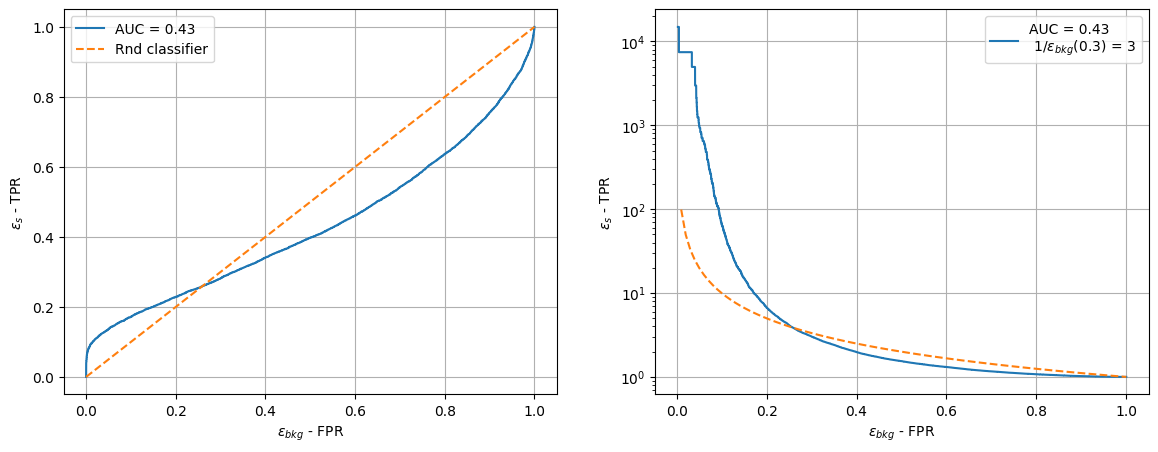

In [31]:


# Function to find index of  next point to given vallue
def closest_point(array, tpr_p=0.3):
    return np.argmin((array - tpr_p) ** 2)


fig, ax = plt.subplots(1, 2, figsize=(14, 5))


print(y_test_mse.shape, test_mse.shape)

# calculate ROC-Kurve-Parameter (fpr, tpr, Schwellenwert) and AUC value
fpr, tpr, th = roc_curve(y_test_mse, test_mse)
auc_score = roc_auc_score(y_test_mse, test_mse)

# generate array fo random classifier
rnd_class = np.linspace(0, 1, 100)


ax[0].plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
ax[0].plot(rnd_class, rnd_class, '--', label='Rnd classifier')


ax[1].plot(tpr, 1/fpr, label=f'AUC = {auc_score:.2f}\n $1/\epsilon_{{bkg}}$(0.3) = {1/fpr[closest_point(tpr, tpr_p=0.3)]:.0f}' if 0 in fpr else '')
ax[1].plot(rnd_class, 1/rnd_class, '--', label='Rnd classifier' if 0 not in rnd_class else '')

ax[1].set_yscale('log')


for ax_i in ax:
    ax_i.set_xlabel('$\epsilon_{bkg}$ - FPR')
    ax_i.set_ylabel('$\epsilon_{s}$ - TPR')
    ax_i.legend()
    ax_i.tick_params()
    ax_i.grid(True)


plt.show()

In [9]:
# TODO: Repeat everything for CNN
class cnn_data(torch.utils.data.Dataset):
    def __init__(self, imgs):
        self.imgs = imgs

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        return self.imgs[idx]


batch_size = 100

trn_top_cnn = torch.utils.data.DataLoader(cnn_data(top_train), batch_size=batch_size, shuffle=True)
tst_top_cnn = torch.utils.data.DataLoader(cnn_data(top_test), batch_size=batch_size, shuffle=False)
val_top_cnn = torch.utils.data.DataLoader(cnn_data(top_val), batch_size=batch_size, shuffle=False)




In [10]:

class CNN_autoencoder(nn.Module):

    def __init__(self, in_ch=1, ch=32, bottleneck_dim=15, img_sz=40):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, ch, kernel_size=3, bias=True, stride=1, padding=1)
        self.conv2 = nn.Conv2d(ch, 2*ch, kernel_size=3, bias=True, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.flatten = nn.Flatten()
        self.out = nn.Linear(int(2*ch*img_sz*img_sz/16), bottleneck_dim, bias=True)
        self.relu = nn.ReLU()

        self.de_in = nn.Linear(bottleneck_dim, int(2*ch*img_sz*img_sz/16), bias=True)
        self.unflatten = nn.Unflatten(1,(2*ch,int(img_sz/4),int(img_sz/4)))
        self.convtranspose1 = nn.Conv2d(2*ch, ch, kernel_size=3, bias=True, stride=1, padding=1)
        self.convtranspose2 = nn.Conv2d(ch, in_ch, kernel_size=3, bias=True, stride=1, padding=1)
        self.maxunpool = nn.MaxUnpool2d(kernel_size=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x, indices1 = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x, indices2 = self.maxpool(x)
        x = self.flatten(x)
        x = self.out(x)

        x = self.de_in(x)
        x = self.unflatten(x)
        x = self.maxunpool(x,indices2)
        x = self.relu(x)
        x = self.convtranspose1(x)
        x = self.maxunpool(x,indices1)
        x = self.relu(x)
        x = self.convtranspose2(x)
        return x

In [12]:
# TODO: Train autoencoder on QCD jets
# Choose the bottleneck dimension between 5 and 20

from tqdm import tqdm


cnn_top = CNN_autoencoder().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_top.parameters(), lr=1e-3)

trn_loss = []
val_loss = []
n_epochs = 100

for epoch in tqdm(range(n_epochs), desc="Training Progress"):
    # Training of model
    for img in trn_top_cnn:
        img = img.to(device)

        optimizer.zero_grad()
        pred = cnn_top(img)
        loss = loss_fn(pred, img)
        loss.backward()
        optimizer.step()

        trn_loss.append(loss.item())

    # Validiation of model for each epoch
    with torch.no_grad():
        single_val_loss = []
        for img in val_top_cnn:
            img = img.to(device)
            pred = cnn_top(img)
            loss = loss_fn(pred, img)
            single_val_loss.append(loss.item())

        val_loss.append(np.mean(single_val_loss))


Training Progress: 100%|██████████| 150/150 [05:34<00:00,  2.23s/it]


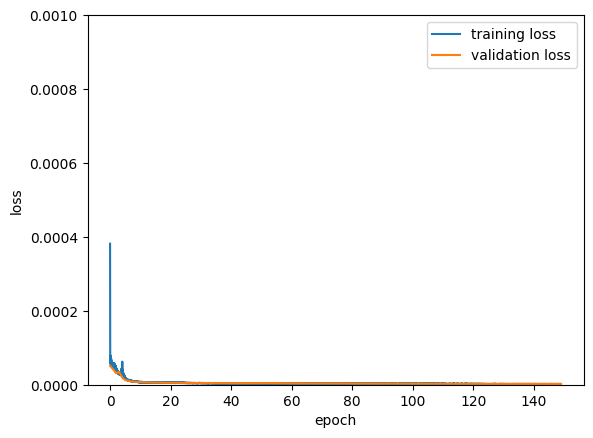

In [13]:
#plotting the loss
plt.plot(np.linspace(0,n_epochs-1,len(trn_loss)), trn_loss,label="training loss")
plt.plot(np.arange(n_epochs),val_loss,label="validation loss")
plt.ylim(0,1e-3)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

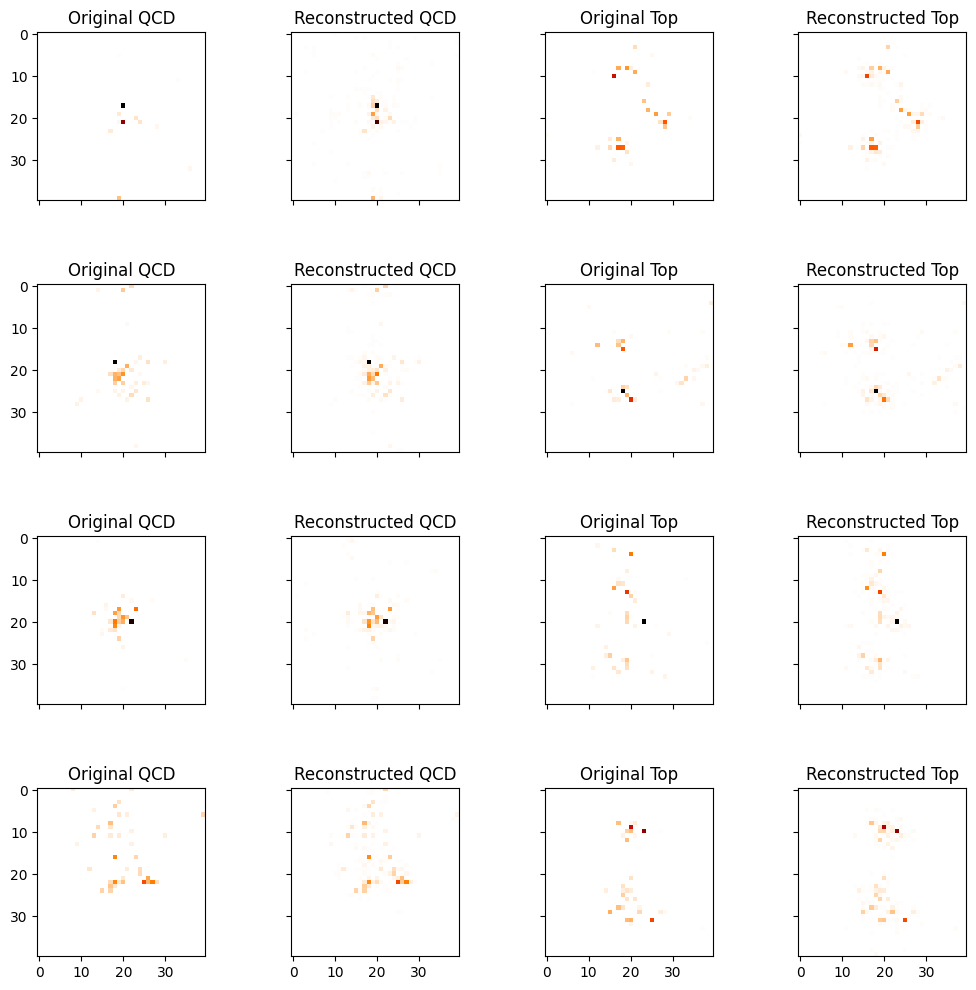

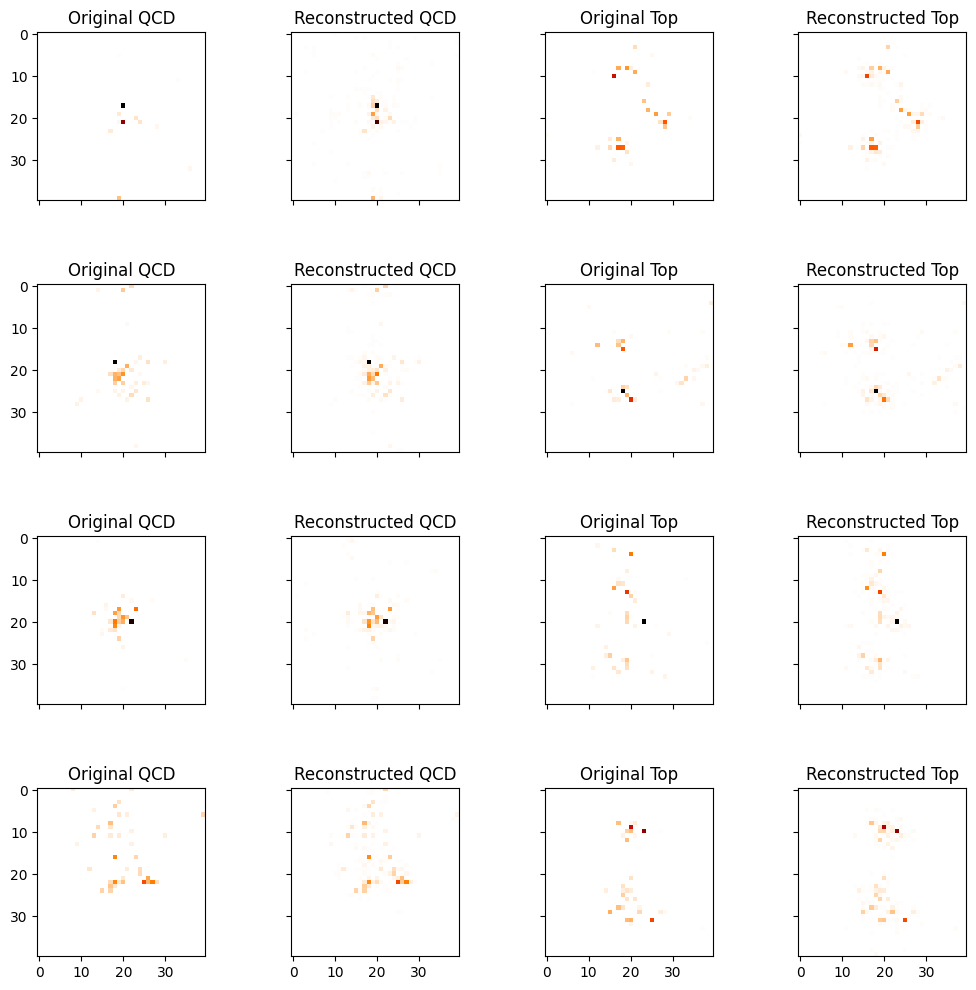

In [15]:
# TODO: Visualize original vs reconstructed QCD and top jets

mse_loss = nn.MSELoss(reduction='none')

# Load test data
qcd_test = torch.Tensor(z_test[np.where(y_test == 0)]).float().to(device)
top_test = torch.Tensor(z_test[np.where(y_test == 1)]).float().to(device)

# Generate predictions
qcd_pred = cnn_top(qcd_test[0:4, :, :, :])
top_pred = cnn_top(top_test[0:4, :, :, :])

# Compute MSE
qcd_mse = mse_loss(qcd_pred, qcd_test[0:4, :, :, :]).cpu().detach().numpy()
top_mse = mse_loss(top_pred, top_test[0:4, :, :, :]).cpu().detach().numpy()

# Reshape predictions for visualization
qcd_pred = np.reshape(qcd_pred.cpu().detach().numpy(), (4, 40, 40))
top_pred = np.reshape(top_pred.cpu().detach().numpy(), (4, 40, 40))


fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(12, 12), sharey=True, sharex=True)

# Plot original QCD images
for i in range(4):
    axs[i,0].imshow(qcd_test[i, 0].cpu(), cmap="gist_heat_r", vmin=0.0, vmax=0.3)
    axs[i,0].set_title("Original QCD")

# Plot reconstructed QCD images
for i in range(4):
    axs[i,1].imshow(qcd_pred[i], cmap="gist_heat_r", vmin=0.0, vmax=0.3)
    axs[i,1].set_title("Reconstructed QCD")

# Plot original Top images
for i in range(4):
    axs[i,2].imshow(top_test[i, 0].cpu(), cmap="gist_heat_r", vmin=0.0, vmax=0.3)
    axs[i,2].set_title("Original Top")

# Plot reconstructed Top images
for i in range(4):
    axs[i,3].imshow(top_pred[i], cmap="gist_heat_r", vmin=0.0, vmax=0.3)
    axs[i,3].set_title("Reconstructed Top")


plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

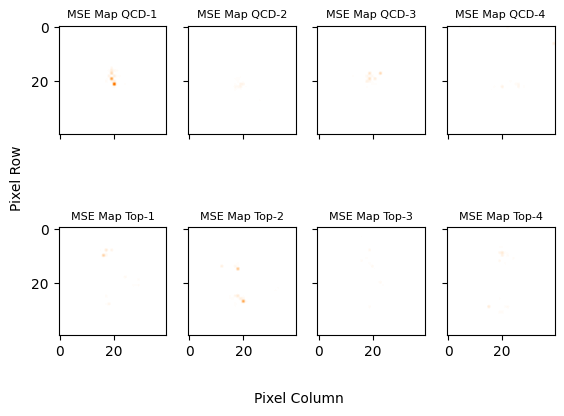

In [16]:
# TODO: Visualize pixel-wise MSE, plot ROC

fig, axs = plt.subplots(nrows=2, ncols=4, sharey=True, sharex=True)

# Reshape the MSE arrays for QCD and Top jets
mse_qcd = np.reshape(qcd_mse, (4, 40, 40))
mse_top = np.reshape(top_mse, (4, 40, 40))

# Plot the MSE maps for QCD jets
for i in range(4):
    axs[0, i].imshow(mse_qcd[i], cmap="gist_heat_r", vmin=0.0, vmax=0.01)
    axs[0, i].set_title(f'MSE Map QCD-{i + 1}', fontsize=8)  # Add title for QCD jets

# Plot the MSE maps for Top jets
for i in range(4):
    axs[1, i].imshow(mse_top[i], cmap="gist_heat_r", vmin=0.0, vmax=0.01)
    axs[1, i].set_title(f'MSE Map Top-{i + 1}', fontsize=8)  # Add title for Top jets


fig.text(0.5, 0.04, 'Pixel Column', ha='center', va='center')
fig.text(0.06, 0.5, 'Pixel Row', ha='center', va='center', rotation='vertical')


plt.show()

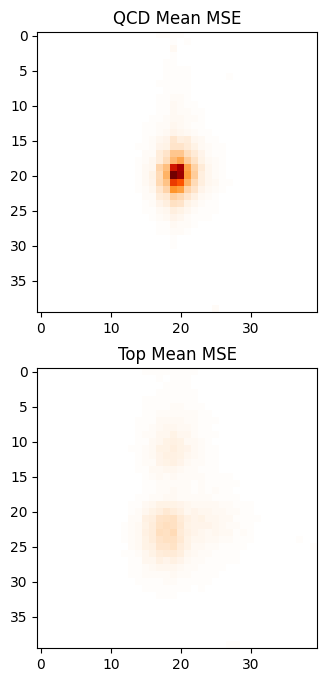

In [21]:
test_loss = nn.MSELoss(reduction='none')

# Convert test data to tensors
TOP_test = torch.Tensor(z_test[np.where(y_test == 1)]).float()
QCD_test = torch.Tensor(z_test[np.where(y_test == 0)]).float()

# Move tensors to device
TOP_test = TOP_test.to(device)
QCD_test = QCD_test.to(device)

# Generate predictions and compute MSE
with torch.no_grad():
    pred_top = cnn_top(TOP_test)
    mse_top = test_loss(pred_top, TOP_test).cpu().detach().numpy()
    mse_top = np.reshape(mse_top, (TOP_test.shape[0], 40, 40))

    pred_qcd = cnn_top(QCD_test)
    mse_qcd = test_loss(pred_qcd, QCD_test).cpu().detach().numpy()
    mse_qcd = np.reshape(mse_qcd, (QCD_test.shape[0], 40, 40))

# Calculate mean MSE and labels
test_mse = np.append(np.mean(mse_top, axis=(-1, -2)), np.mean(mse_qcd, axis=(-1, -2)))
y_test_mse = np.append(np.zeros(mse_top.shape[0]), np.ones(mse_qcd.shape[0]))

# Calculate mean MSE for visualization
mse_qcd_mean = np.mean(mse_qcd, axis=0)
mse_top_mean = np.mean(mse_top, axis=0)


fig, [ax0, ax1] = plt.subplots(2, figsize=(8, 8))
ax0.imshow(mse_qcd_mean, vmin=0, vmax=0.0005, cmap="gist_heat_r")
ax0.set_title("QCD Mean MSE")

ax1.imshow(mse_top_mean, vmin=0, vmax=0.0005, cmap="gist_heat_r")
ax1.set_title("Top Mean MSE")

plt.show()

(30000,) (30000,)


<ipython-input-22-8acf66c2becc>:23: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(tpr, 1/fpr, label=f'AUC = {auc_score:.2f}\n $1/\epsilon_{{bkg}}$(0.3) = {1/fpr[closest_point(tpr, tpr_p=0.3)]:.0f}' if 0 in fpr else '')
<ipython-input-22-8acf66c2becc>:24: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(rnd_class, 1/rnd_class, '--', label='Rnd classifier' if 0 not in rnd_class else '')


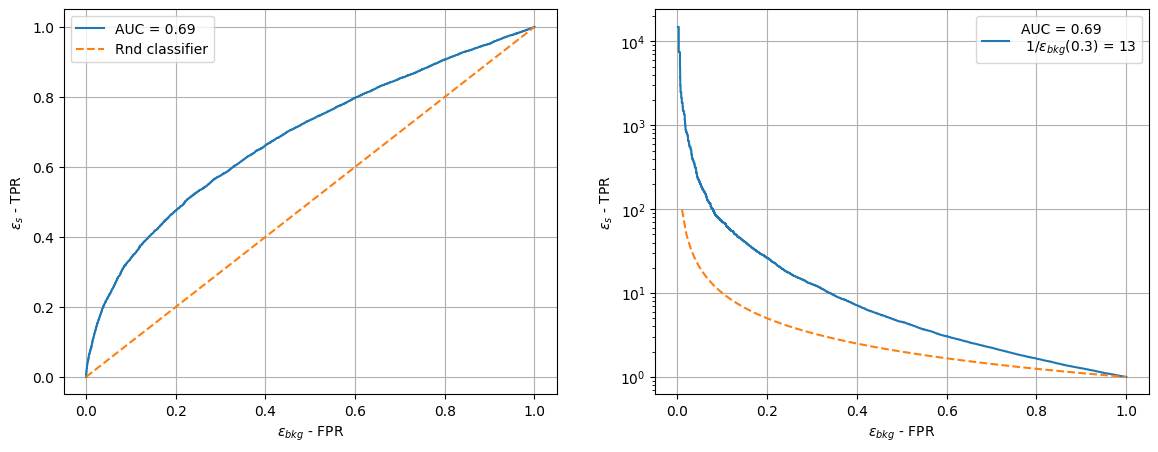

In [22]:
# funcion to find index of next point to a given value
def closest_point(array, tpr_p=0.3):
    return np.argmin((array - tpr_p) ** 2)


fig, ax = plt.subplots(1, 2, figsize=(14, 5))


print(y_test_mse.shape, test_mse.shape)

# calculate ROC-Kurve-Parameter and AUC value
fpr, tpr, th = roc_curve(y_test_mse, test_mse)
auc_score = roc_auc_score(y_test_mse, test_mse)

# generate array for random classifier
rnd_class = np.linspace(0, 1, 100)


ax[0].plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
ax[0].plot(rnd_class, rnd_class, '--', label='Rnd classifier')


ax[1].plot(tpr, 1/fpr, label=f'AUC = {auc_score:.2f}\n $1/\epsilon_{{bkg}}$(0.3) = {1/fpr[closest_point(tpr, tpr_p=0.3)]:.0f}' if 0 in fpr else '')
ax[1].plot(rnd_class, 1/rnd_class, '--', label='Rnd classifier' if 0 not in rnd_class else '')


ax[1].set_yscale('log')

for ax_i in ax:
    ax_i.set_xlabel('$\epsilon_{bkg}$ - FPR')
    ax_i.set_ylabel('$\epsilon_{s}$ - TPR')
    ax_i.legend()
    ax_i.tick_params()
    ax_i.grid(True)

plt.show()